# Sketch-RNN with Keras

In this notebook we will play around with the models we trained using the [Keras Sketch-RNN](https://github.com/eyalzk/sketch_rnn_keras).
We will load the trained models, draw some sketches, travel along the latent space and explore what our model has learned.

many examples in this notebook are ported to keras from the [official Magenta demo](https://github.com/tensorflow/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb) and some are my own.

First, let's set our experiment directory and the checkpoint file that we want to load.

We'll start with a model trained on cats:

In [154]:
# Path to data directory 
data_dir  = 'datasets'
# Path to the experiment directory that was created during training
exp_dir = 'examples\experiments\cat'
# Checkpoint file name (assumed in checkpoints folder within exp_dir)
weights_fname = 'weights.hdf5'

Now let's do some imports and define functions that we will use later on:

In [152]:
import os
import copy
from utils import *
from seq2seqVAE_train import *
import seq2seqVAE as sketch_rnn_model
from seq2seqVAE import sample

In [3]:
# disable gpu access so this notebook can run during training (optional)
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [4]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import svgwrite 
# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

The following few functions are mostly the same as in the official Magenta demo

In [5]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
    if not os.path.exists(os.path.dirname(svg_filename)):
        os.makedirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)
    
        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])
    
        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)

Read parameter file and load data:

In [155]:
with open(os.path.join(exp_dir,'logs', 'model_config.json'), 'r') as f:
    model_params = json.load(f)
model_params = DotDict(model_params)   
[train_set, valid_set, test_set, hps_model] = load_dataset(data_dir, model_params)

Loaded 70000/2500/2500 from cat.npz
Dataset combined: 75000 (70000/2500/2500), avg len 69
model_params.max_seq_len: 129
total images <= max_seq_len is 70000
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500
normalizing_scale_factor  43.17017


Build a Seq2seq variational autoencoder model and load weights from checkpoint:

In [156]:
weights = os.path.join(exp_dir,'checkpoints',weights_fname) # checkpoint path
seq2seq = Seq2seqModel(model_params)  # build model
seq2seq.load_trained_weights(weights) # load checkpoint
seq2seq.make_sampling_models()  # build sub models that are used to infuse inputs and probe values of intermediate layers

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 129, 5)       0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          65664       bidirectional_5[0][0]            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          65664       bidirectional_5[0][0]            
__________________________________________________________________________________________________
lambda_9 (

In [8]:
# Function for encoding input and retrieving latent vector
def encode(input_strokes, draw=False):
    strokes = to_big_strokes(input_strokes, max_len=model_params['max_seq_len']-1).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    if draw:
        draw_strokes(to_normal_strokes(np.array(strokes)))
    strokes = np.expand_dims(strokes, axis=0)
    return seq2seq.sample_models['encoder_model'].predict(strokes)


In [9]:
# Function for decoding a latent space factor into a sketch
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
    z = None
    if z_input is not None:
        z = z_input
    sample_strokes, m = sample(seq2seq, seq_len=model_params.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    if draw_mode:
        draw_strokes(strokes, factor)
    return strokes

Let's take a random sketch from the unseen test set and draw it:

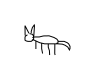

In [328]:
# Get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg/sample.svg')

Now we will encode this sketch into the latent space.

Note that our encoder was constructed to be non-deterministic. So the same sketch will be encoded to different latent representations each time we encode.

In [329]:
z = encode(stroke)

Now we decode this encoded representation back to a sketch:

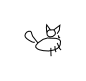

In [331]:
_ = decode(z, temperature=0.5) # convert z back to drawing at temperature of 0.5


The temperature variable controls the level of randomness we would like our samples to have during the
sampling (equation 8 of the sketch-rnn [paper](https://arxiv.org/pdf/1704.03477.pdf)).

Let's decode our cat using varying temperature values between 0.1 and 1 and see how 'creative' our model can get:

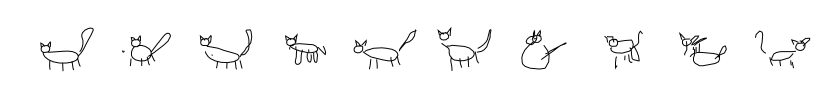

In [332]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

OK, so we saw how to encode and decode a single sketch.
Now let's see what happens when we interpolate between two different cats!

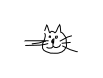

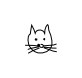

In [410]:
z0 = z

# Get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg/sample.svg')
z1 = encode(stroke)
_ = decode(z1) # convert z back to drawing at temperature of 0.5

z1 = np.squeeze(z1)
z0 = np.squeeze(z0)

In [124]:
def interpolate_z(z_0, z_1, draw=True):
    z_list = [] # interpolate spherically between z0 and z1
    N = 10
    for t in np.linspace(0, 1, N):
        z_list.append(slerp(z_0, z_1, t))
    # for every latent vector in z_list, sample a vector image
    reconstructions = []
    for i in range(N):
        reconstructions.append([decode(np.expand_dims(z_list[i],axis=0), draw_mode=False), [0, i]])
    stroke_grid = make_grid_svg(reconstructions)
    if draw:
        draw_strokes(stroke_grid)

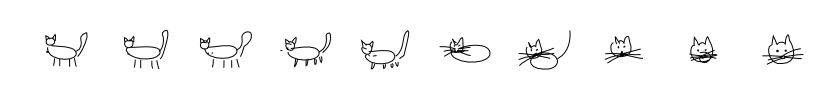

In [411]:
interpolate_z(z0,z1)

Since this is a Variational Autoencoder, we don't need to use an actual sketch in order to generate new sketches. We can sample randomly within the latent space and feed the result to the decoder.

Let's let our model draw some random cats!

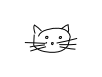

In [435]:
random_cat_1 = np.expand_dims(np.random.randn(model_params.z_size),0)
_ = decode(random_cat_1)

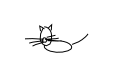

In [601]:
random_cat_2 = np.expand_dims(np.random.randn(model_params.z_size),0)
_ = decode(random_cat_2)

Again, we can intepulate between our 2 random cats:

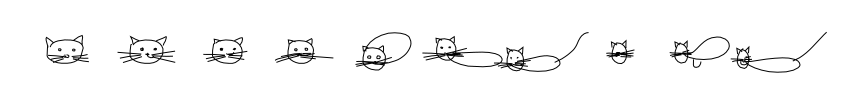

In [603]:
random_cat_1 = np.squeeze(random_cat_1)
random_cat_2 = np.squeeze(random_cat_2)
# interpolate_z(random_cat_2,random_cat_2)
interpolate_z(random_cat_1,random_cat_2)

### Using a model trained on more than one data-set
Now let's load a model trained on both **cats** and **guitars**.

In [150]:
# Path to the experiment directory that was created during training
exp_dir = 'examples\experiments\cat_guitar'
# Checkpoint file name (assumed in checkpoints folder within exp_dir)
weights_fname = 'weights.hdf5'

In [98]:
with open(os.path.join(exp_dir,'logs', 'model_config.json'), 'r') as f:
    model_params = json.load(f)
model_params = DotDict(model_params)   
[train_set, valid_set, test_set, hps_model] = load_dataset(data_dir, model_params)

Loaded 70000/2500/2500 from cat.npz
Loaded 70000/2500/2500 from guitar.npz
Dataset combined: 150000 (140000/5000/5000), avg len 70
model_params.max_seq_len: 129
total images <= max_seq_len is 140000
total images <= max_seq_len is 5000
total images <= max_seq_len is 5000
normalizing_scale_factor  51.59792


In [151]:
weights = os.path.join(exp_dir,'checkpoints',weights_fname) # checkpoint path
seq2seq = Seq2seqModel(model_params)  # build model
seq2seq.load_trained_weights(weights) # load checkpoint
seq2seq.make_sampling_models()  # build sub models that are used to infuse inputs and probe values of intermediate layers

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 129, 5)       0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          65664       bidirectional_4[0][0]            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 128)          65664       bidirectional_4[0][0]            
__________________________________________________________________________________________________
lambda_7 (

Cat sketch reconstruction:

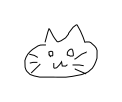

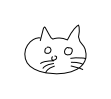

In [133]:
# Get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg/sample.svg')
z_cat = encode(stroke)
_ = decode(z_cat) # convert z back to drawing at temperature of 0.5

Guitar sketch reconstruction:

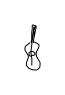

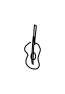

In [148]:
# Get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke,svg_filename = '/tmp/sketch_rnn/svg/sample.svg')
z_guitar = encode(stroke)
_ = decode(z_guitar) # convert z back to drawing at temperature of 0.5

z_guitar = np.squeeze(z_guitar)
z_cat = np.squeeze(z_cat)

Interpolating from cat to guitar!

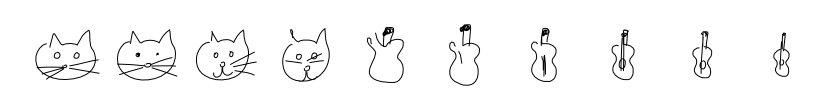

In [149]:
interpolate_z(z_cat,z_guitar)

Examples in this notebook use models trained on my laptop's GPU:
  * Cat model : 50 epochs
  * Cat + Guitar model: 15 epochs
 
Given more time and resources I expect results to be even better than ones shown here.